# Autoencoder Pipeline with Image Preprocessing and Evaluation

This notebook sets up an autoencoder model using TensorFlow and applies it to a dataset of paired grayscale images. It includes data augmentation, preprocessing, model definition, training, evaluation, and visualization.

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import Model, load_model
from keras.datasets import mnist
from itertools import product
from tensorflow.data import AUTOTUNE
import os
import math
import random
import scienceplots

plt.style.use('science')

2025-06-02 02:29:41.967491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 02:29:41.968192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 02:29:41.971923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 02:29:41.982269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748827781.999887 1015572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748827782.00

## Parameters and Constants
Defining batch sizes and last layer activation functions. The selected configuration will guide the training run.

In [ ]:
batch_sizes = (4, 8, 16, 32, 64)
last_activations = ("linear", "relu", "sigmoid", "tanh")

chosen_parameters = [64, "linear"]

num_epochs = 50

print(f"Running test with parameters: {chosen_parameters}")

batch_size = int(chosen_parameters[0])
last_activation = chosen_parameters[1]

DATASET_BUFFER_SIZE = 1000
DATASET_BATCH_SIZE = batch_size

IMG_WIDTH = 256
IMG_HEIGHT = 256

Running test with parameters: [64, 'linear']


## Data Augmentation
Define a sequential pipeline of augmentations applied to images during training: random rotation, zoom, contrast, and brightness adjustments.

In [4]:
data_augment = tf.keras.Sequential([
    layers.RandomRotation(factor=1.0, fill_mode='reflect'),
    layers.RandomZoom(0.1, 0.1, fill_mode='reflect'),
    layers.RandomContrast(0.05),
    layers.RandomBrightness(0.05),
])

E0000 00:00:1748827783.518125 1015572 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748827783.518538 1015572 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Preprocessing Function
Loads a paired image (input + target) and applies preprocessing including augmentation (during training), resizing, and z-score normalization.

In [5]:
def preprocess_pair(path, training):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=1)
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :]
    inp  = img[:, w:, :]

    if training:
        pair = tf.concat([inp, real], axis=2)
        pair = data_augment(pair)
        inp, real = tf.split(pair, num_or_size_splits=2, axis=2)

    inp  = tf.image.resize(inp,  [IMG_WIDTH, IMG_HEIGHT], method='bilinear')
    real = tf.image.resize(real, [IMG_WIDTH, IMG_HEIGHT], method='bilinear')

    inp_mean, inp_var = tf.nn.moments(inp, axes=[0,1])
    real_mean, real_var = tf.nn.moments(real, axes=[0,1])
    inp  = (inp  - inp_mean)  / tf.sqrt(inp_var  + 1e-6)
    real = (real - real_mean) / tf.sqrt(real_var + 1e-6)

    return inp, real

## Dataset Creation
Wraps preprocessing logic into TensorFlow datasets for both training and testing sets. Uses shuffling and prefetching for performance.

In [6]:
def make_ds(pattern, training):
    ds = tf.data.Dataset.list_files(pattern)
    if training:
        ds = ds.shuffle(DATASET_BUFFER_SIZE)
    ds = ds.map(lambda p: preprocess_pair(p, training),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(DATASET_BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_dataset = make_ds('./data/TCIRRP/train1k/*.jpg', training=True)
test_dataset  = make_ds('./data/TCIRRP/test0.1k/*.jpg',  training=False)
test_dataset_full = make_ds('./data/TCIRRP/test/*.jpg', training=False)

## Autoencoder Definition
Custom model with convolutional encoder and decoder. Latent representation is a vector of size 32. The decoder reconstructs the original image.

In [7]:
LATENT_DIMENSIONS = 32

class Autoencoder(Model):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
            layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Flatten(),
            layers.Dense(LATENT_DIMENSIONS, activation='relu'),
        ])
        self.bw = math.ceil(IMG_WIDTH / 2**3)
        self.bh = math.ceil(IMG_HEIGHT / 2**3)
        self.bc = 128
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(LATENT_DIMENSIONS,)),
            layers.Dense(self.bw * self.bh * self.bc, use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Reshape((self.bw, self.bh, self.bc)),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation=last_activation),
        ])
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

## Model Loading or Compilation
Attempts to load an existing model if available, otherwise compiles a new one.

In [8]:
input_epoch = 0
input_model_path = f"0.01k-{input_epoch}Epochs-32Lat-{batch_size}Batch-{last_activation}.keras"
output_epoch = num_epochs
output_model_path = f"0.01k-{output_epoch}Epochs-32Lat-{batch_size}Batch-{last_activation}.keras"
log_dir = f"logs/fit/v2-autoencoder-0.01k-32Lat-{last_activation}-{batch_size}Batch"

if os.path.exists(input_model_path):
    print("\033[92mModel loaded. With evaluation:\033[0m")
    autoencoder = load_model(input_model_path, custom_objects={'Autoencoder': Autoencoder})
    autoencoder.evaluate(test_dataset, verbose=2)
    print(autoencoder.optimizer.get_config())
else:
    print("Model not loaded")
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=[tf.keras.metrics.Accuracy()])

Model not loaded


## Training
Train the model and save checkpoints, along with TensorBoard logging for deeper analysis.

In [9]:
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=output_model_path, verbose=2, monitor='val_loss')

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=5,
    write_graph=True,
)

autoencoder.fit(
    train_dataset,
    epochs=output_epoch,
    initial_epoch=input_epoch,
    validation_data=test_dataset,
    callbacks=[save_callback, tensorboard_cb],
)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.0000e+00 - loss: 0.9885
Epoch 1: saving model to 0.01k-1Epochs-32Lat-64Batch-linear.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 644ms/step - accuracy: 0.0000e+00 - loss: 0.9866 - val_accuracy: 0.0000e+00 - val_loss: 0.8952


## Evaluation and Visualization
Evaluates the final model and visualizes the input, predicted output, and ground truth side by side.





Final evaluation:
93/93 - 16s - 175ms/step - accuracy: 2.5636e-09 - loss: 0.8902
Final evaluation result: [0.8902298212051392, 2.5636406331130956e-09]


2025-06-02 02:30:41.818579: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-02 02:30:43.662247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


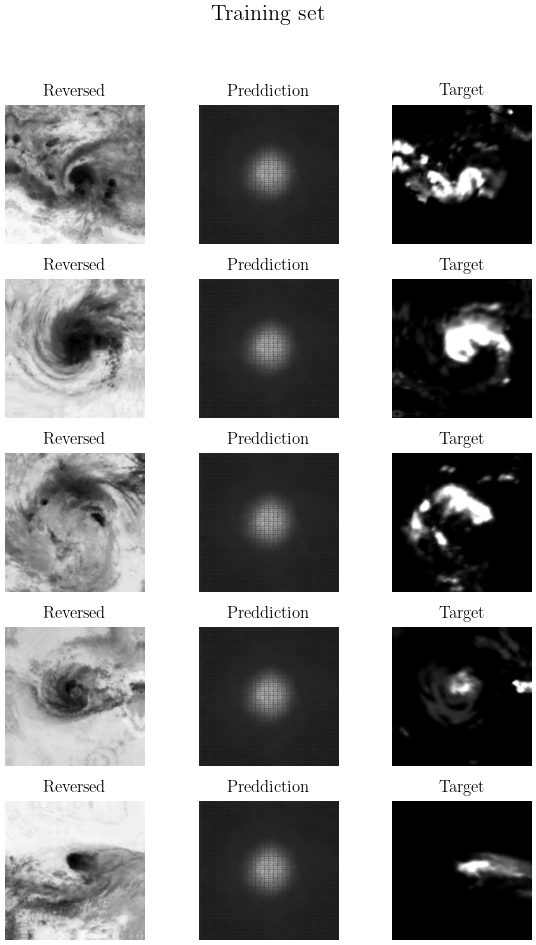

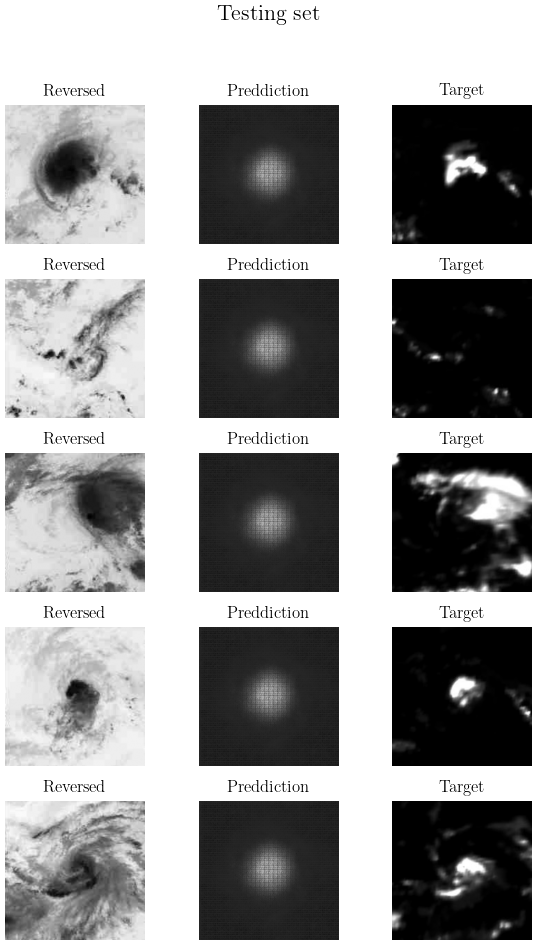

In [11]:
print("\n\n\n")

print("Final evaluation:")
ev = autoencoder.evaluate(test_dataset_full, verbose=2)
# results.append((batch_size, last_activation, ev[0]))
print("Final evaluation result:", ev)

# print(results)

num_tests = 5

for name, dataset in [("Training set", train_dataset), ("Testing set", test_dataset)]:
    x_input = []
    x_real  = []
    for input_batch, real_batch in dataset.take(num_tests):
        x_input.extend(input_batch)
        x_real.extend(real_batch)
    x_input = tf.stack(x_input)
    x_real  = tf.stack(x_real)

    encoded_imgs = autoencoder.encoder(x_input).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    plt.figure(figsize=(6, num_tests * 2))
    plt.suptitle(name, fontsize=16)
    for i in range(num_tests):
        ax = plt.subplot(num_tests, 3, i*3 + 1)
        plt.imshow(x_input[i].numpy(), cmap="gray")
        ax.set_title("Reversed")
        ax.axis("off")

        ax = plt.subplot(num_tests, 3, i*3 + 2)
        plt.imshow(decoded_imgs[i], cmap="gray")
        ax.set_title("Preddiction")
        ax.axis("off")

        ax = plt.subplot(num_tests, 3, i*3 + 3)
        plt.imshow(x_real[i].numpy(), cmap="gray")
        ax.set_title("Target")
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()